In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Reshape, Conv2D, Conv2DTranspose, Flatten, Dropout
from tensorflow.keras.models import Model
import numpy as np
from tensorflow.keras.optimizers import RMSprop
import os
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing import image

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image

# [5월 18일]
---

## # 적대적 생성 신경망 (Generative Adversarial Networks, GAN)
---
- 2014년, Ian Goodfellow 소개

- VAE와는 다른 방법으로 이미지 잠재 공간을 학습

- 직관적으로 이해하는 방법

  - 가짜 피카소 그림을 그리는 위조범과 이를 판별하는 판매상의 관계

  - 위조품과 진짜 그림을 섞어서 판매상에게 보여주며  
    그림이 진짜인지 가짜인지 판매상은 판별하고 이를 위조범에게 피드백

  - 처음에는 형편없는 그림을 그리다가 점점 피카소의 스타일을 모방하게 되고  
    판매상은 위조품을 구분하는데 점점 더 전문가가 되어감

- GAN의 네트워크

  - 생성자 네트워크(generator network)

    - 랜덤 벡터(잠재 공간의 무작위한 포인트)를 입력으로 받아 이를 합성된 이미지로 디코딩

  - 판별자 네트워크(discriminator netowrk)

    - 이미지(실제 또는 가짜 이미지)를 입력으로 받아 훈련 세트에서 온 이미지인지 생성자가 만든 이미지인지 판별

- GAN은 최적화의 최솟값이 고정되어 있지 않음

  - 보통의 경사하강법은 **고정된 손실공간**에서 언덕을 내려오는 훈련 방법이지만  
    GAN은 매 단계가 조금씩 전체 공간을 바꾸기 때문에 최적화 과정이 최솟값을 찾는 것이 어려움

  - 두 힘간의 평형점을 찾는 시스템

  - 따라서, 학습과정이 매우 어려움  
    즉, 적절한 파라미터를 찾고 조정해야함
  
  <img src="https://paperswithcode.com/media/methods/gan.jpeg">

  <sub>[이미지 출처] https://paperswithcode.com/method/gan</sub>
  $$$$

### # GAN의 구현 (DCGAN)
---
- CIFAR10 데이터셋 사용

- generator 네트워크는 (latent_dim,) 크기의 벡터를 (32, 32, 3) 크기의 이미지로 매핑

- discriminator 네트워크는 (32, 32, 3) 크기의 이미지가 진짜일 확률을 추정하여 이진값으로 매핑

- 생성자와 판별자를 연결하는 gan 네트워크를 만듬  
  
  - gan(x) = discriminator(generator(x))

- 진짜/가짜 레이블과 함께 진짜 이미지와 가짜 이미지 샘플을 사용하여 판별자를 훈련 (일반적인 이미지 분류 모델 훈련과 동일)

- 생성자를 훈련하려면 gan 모델의 손실에 대한 생성자 가중치의 그래디언트를 사용

  - 매 단계마다 생성자에 의해 디코딩된 이미지를 판별자가 "진짜"로 분류하도록 한다는 방향으로 생성자의 가중치를 이동

  - 판별자를 속이도록 생성자를 훈련한다는 말
$$$$

### # 학습 방법
---
- 마지막 활성화 함수로 sigmoid 대신 tanh함수 사용

- 균등분포가 아니고 정규 분포(가우시안 분포)를 사용하여 잠재 공간에서 포인트를 샘플링

- 무작위성을 주입

  - 판별자에 드롭아웃을 사용

  - 판별자를 위해 레이블에 랜덤 노이즈를 추가

- 희소한 그래디언트는 GAN 훈련에 방해가 될 수 있음

  - 최대 풀링 대신 스트라이드 합성곱을 사용하여 다운샘플링

  - ReLU 대신 LeakyReLU 사용
  
  - LeakyReLU : https://gooopy.tistory.com/56
  
- 생성자에서 픽셀 공간을 균일하게 다루지 못하여 생성된 이미지에서 체스판 모양이 종종 나타남.  
  이를 위해 생성자와 판별자에서 스트라이드 Conv2DTranpose나 Conv2D를 사용할 때 스트라이드 크기로 나누어 질 수 있는 커널 크기 사용

  - 커널 크기가 스트라이드의 배수가 아니면 픽셀이 공평하게 합성곱 되지 않음  
    커널 크기를 스트라이드로 나누었을 때 나머지 크기에 해당하는 픽셀이 더 많이 업샘플링에 참여하게 됨



## # DCGAN 구현
---

### # 생성자 네트워크
---

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Reshape, Conv2D, Conv2DTranspose, Flatten, Dropout
from tensorflow.keras.models import Model
import numpy as np

latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = Input(shape = (latent_dim,))

# 입력을 16 x 16 크기의 채널 128개를 가진 특성맵으로 변환
x = Dense(128 * 16 * 16)(generator_input)
x = LeakyReLU()(x)
x = Reshape((16, 16, 128))(x)

# 32 x 32 크기로 업샘플링
x = Conv2DTranspose(256, 4, strides = 2, padding = 'same')(x)
x = LeakyReLU()(x)

x = Conv2D(256, 5, padding = 'same')(x)
x = LeakyReLU()(x)
x = Conv2D(256, 5, padding = 'same')(x)
x = LeakyReLU()(x)

# 32 x 32 크기의 1개 채널을 가진 특성 맵을 생성
x = Conv2D(channels, 7, activation = 'tanh', padding = 'same')(x)
generator = Model(generator_input, x) # (latent_dim,) 크기의 입력을 (32, 32, 3) 크기의 이미지로 매핑하는 생성자 모델 객체를 만듦
generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_3 (Dense)             (None, 32768)             1081344   
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 32768)             0         
                                                                 
 reshape_3 (Reshape)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 32, 32, 256)       0         
                                                             

### # 판별자 네트워크
---

In [ ]:
from tensorflow.keras.optimizers import RMSprop

discriminator_input = Input(shape = (height, width, channels))

x = Conv2D(128, 3)(discriminator_input)
x = LeakyReLU()(x)
x = Conv2D(128, 4, strides = 2)(x)
x = LeakyReLU()(x)
x = Conv2D(128, 4, strides = 2)(x)
x = LeakyReLU()(x)
x = Conv2D(128, 4, strides = 2)(x)
x = LeakyReLU()(x)
x = Flatten()(x)

x = Dropout(0.4)(x)

x = Dense(1, activation = 'sigmoid')(x)

discriminator = Model(discriminator_input, x)

discriminator_optimizer = RMSprop(learning_rate = 0.0008,
                                  clipvalue = 1.0,
                                  decay = 1e-8)
discriminator.compile(optimizer = discriminator_optimizer, loss = 'binary_crossentropy')

discriminator.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_25 (Conv2D)          (None, 30, 30, 128)       3584      
                                                                 
 leaky_re_lu_29 (LeakyReLU)  (None, 30, 30, 128)       0         
                                                                 
 conv2d_26 (Conv2D)          (None, 14, 14, 128)       262272    
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                                 
 conv2d_27 (Conv2D)          (None, 6, 6, 128)         262272    
                                                                 
 leaky_re_lu_31 (LeakyReLU)  (None, 6, 6, 128)         0   

### # 적대적 네트워크
---

In [ ]:
discriminator.trainable = False # 판별자의 가중치가 훈련되지 않도록 설정

gan_input = Input(shape = (latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)

gan_optimizer = RMSprop(learning_rate = 0.0004, clipvalue = 1.0, decay = 1e-8)
gan.compile(optimizer = gan_optimizer, loss = 'binary_crossentropy')

### # 모델 훈련
---

In [ ]:
import os
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing import image

(x_train, y_train), (_, _) = cifar10.load_data()

# 개구리 이미지를 선택 (클래스 6)
x_train = x_train[y_train.flatten() == 6]

# 데이터 정규화
x_train = x_train.reshape((x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.

save_dir = './gan_images/'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

170508288/170498071 [==============================] - 4s 0us/step


In [ ]:
iterations = 10000
batch_size = 32

start = 0
for step in range(iterations):

    # 잠재 공간에서 무작위로 포인트를 샘플링
    random_latent_vectors = np.random.normal(size = (batch_size, latent_dim))

    # 랜덤 노이즈를 사용하여 이미지를 생성 (가짜 이미지를 디코딩)
    generated_images = generator.predict(random_latent_vectors)

    # 생성된 이미지와 진짜 이미지를 섞음
    stop = start + batch_size
    real_images = x_train[start:stop]
    combined_images = np.concatenate([generated_images, real_images])

    # 진짜와 가짜 이미지를 구분하여 레이블을 합침
    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])

    # 레이블에 랜덤 노이즈를 추가
    labels += 0.05 * np.random.random(labels.shape)

    # 진짜와 가짜가 섞인 이미지와 이에 대응하는 타깃을 사용하여 discriminator를 훈련
    d_loss = discriminator.train_on_batch(combined_images, labels)

    #잠재 공간에서 무작위로 포인트를 샘플링
    random_latent_vectors - np.random.normal(size = (batch_size, latent_dim))

    # 모든 타겟을 진짜 이미지로 설정
    # 판별자가 생성된 이미지를 모두 진짜 이미지라고 예측하도록 생성자의 가중치를 업데이트
    # gan 안에서 판별자는 동결되기 때문에 생성자만 업데이트, 결국 생성자는 판별자를 속이도록 훈련
    misleading_targets = np.zeros((batch_size, 1))
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)

    start += batch_size
    if start > len(x_train) - batch_size:
        start = 0
    
    # 100번 스텝마다 저장하고 그래프를 그림
    if step % 100 == 0:
        gan.save_weights('gan.h5')

        print(f'스텝 {step}에서 판별자 손실 : {d_loss}')
        print(f'스텝 {step}에서 적대자 손실 : {a_loss}')

        # 생성된 이미지 저장
        img = image.array_to_img(generated_images[0] * 255., scale = False)
        img.save(os.path.join(save_dir, 'generated_frog' + str(step) + '.png'))

        # 진짜 이미지 저장
        img = image.array_to_img(real_images[0] * 255., scale = False)
        img.save(os.path.join(save_dir, 'real_frog' + str(step) + '.png'))

스텝 0에서 판별자 손실 : 3.39043927192688
스텝 0에서 적대자 손실 : 10.719223022460938
스텝 100에서 판별자 손실 : 0.6922452449798584
스텝 100에서 적대자 손실 : 0.7465122938156128
스텝 200에서 판별자 손실 : 0.6900859475135803
스텝 200에서 적대자 손실 : 0.760816216468811
스텝 300에서 판별자 손실 : 0.6876485347747803
스텝 300에서 적대자 손실 : 0.7569188475608826
스텝 400에서 판별자 손실 : 0.7008642554283142
스텝 400에서 적대자 손실 : 0.7797638177871704
스텝 500에서 판별자 손실 : 0.696976900100708
스텝 500에서 적대자 손실 : 0.7470593452453613
스텝 600에서 판별자 손실 : 0.6891310811042786
스텝 600에서 적대자 손실 : 0.7813104391098022
스텝 700에서 판별자 손실 : 0.6965131163597107
스텝 700에서 적대자 손실 : 0.7634786367416382
스텝 800에서 판별자 손실 : 0.6932307481765747
스텝 800에서 적대자 손실 : 0.7364237308502197
스텝 900에서 판별자 손실 : 0.6983845233917236
스텝 900에서 적대자 손실 : 0.7361097931861877
스텝 1000에서 판별자 손실 : 0.6987826228141785
스텝 1000에서 적대자 손실 : 0.7520838379859924
스텝 1100에서 판별자 손실 : 0.6907225847244263
스텝 1100에서 적대자 손실 : 0.7140507698059082
스텝 1200에서 판별자 손실 : 0.6949819326400757
스텝 1200에서 적대자 손실 : 0.7614396810531616
스텝 1300에서 판별자 손실 : 0.6895304322242737
스텝

### # 생성 이미지 시각화
---

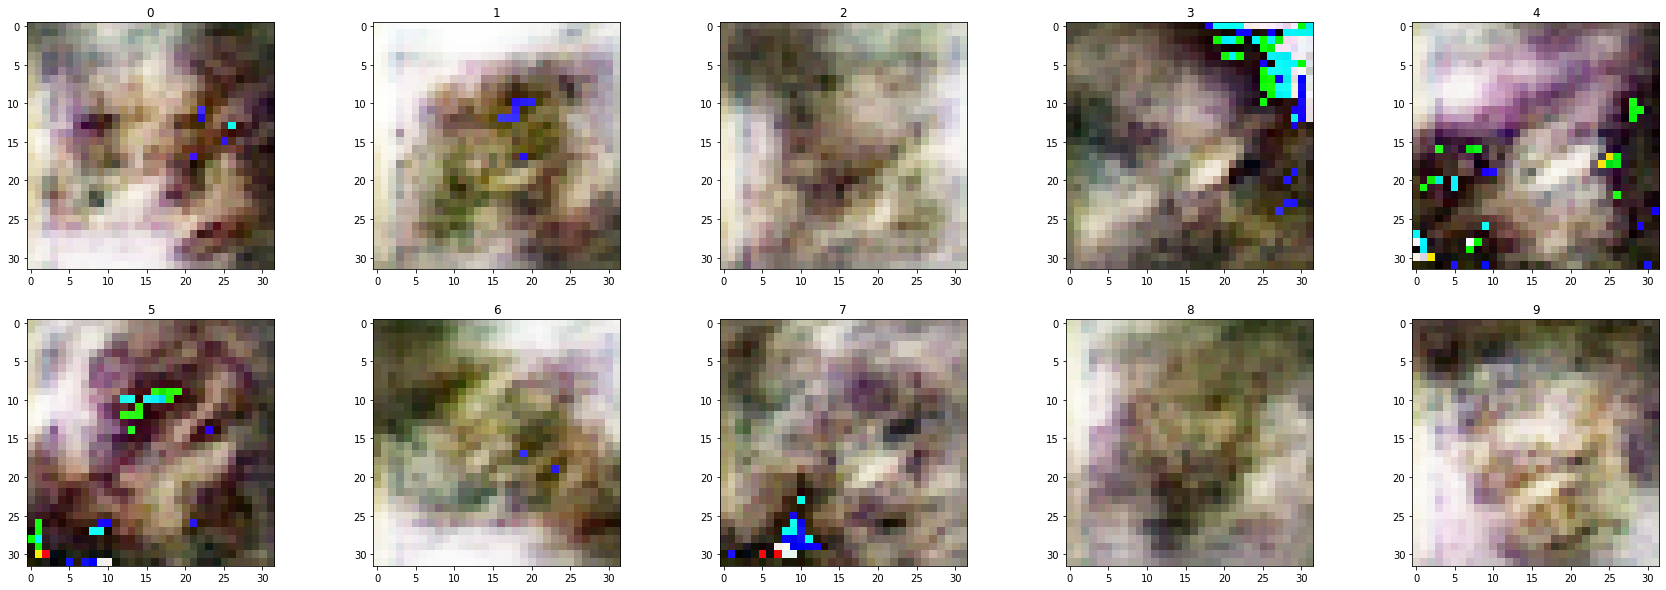

In [ ]:
import matplotlib.pyplot as plt

# 잠재 공간에서 랜덤한 포인트를 샘플링
random_latent_vectors = np.random.normal(size = (10, latent_dim))

# 가짜 이미지로 디코딩
generated_images = generator.predict(random_latent_vectors)

plt.figure(figsize=(30,10))
for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.subplot(2,5,i+1)
    plt.title(i)
    plt.imshow(img)
    
plt.show()

# [5월 19일]
---

## # DCGAN PyTorch로 구현
---

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image

### # 데이터 불러오기
---

In [ ]:
transforms_train = transforms.Compose([transforms.Resize(28),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5], [0.5])
                                       ])

train_dataset = datasets.MNIST(root="./dataset", train = True, download = True, transform = transforms_train)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 128, shuffle = True, num_workers = 4)

### # 생성자 네트워크
---

In [ ]:
latent_dim = 100

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # 하나의 블록(block) 정의
        def block(input_dim, output_dim, normalize = True):
            layers = [nn.Linear(input_dim, output_dim)]
            if normalize:
                layers.append(nn.BatchNorm1d(output_dim, 0.8)) # 배치 정규화 수행(차원 동일)
            layers.append(nn.LeakyReLU(0.2, inplace = True))
            return layers

        # 생성자 모델은 연속적인 여러 개의 블록
        self.model = nn.Sequential(*block(latent_dim, 128, normalize = False),
                                   *block(128, 256),
                                   *block(256, 512),
                                   *block(512, 1024),
                                   nn.Linear(1024, 1 * 28 * 28),
                                   nn.Tanh()
                                   )
        
    def forward(self, z):
        img = self.model(z) # 노이즈 벡터 z

        # 이미지 형태로 만들어 줌
        img = img.view(img.size(0), 1, 28, 28) # 배치 사이즈, 채널, 넓이, 높이
        return img

### # 판별자 네트워크
---

In [ ]:
# 판별자(Discriminator) 클래스 정의
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(nn.Linear(1 * 28 * 28, 512),
                                   nn.LeakyReLU(0.2, inplace = True),
                                   nn.Linear(512, 256),
                                   nn.LeakyReLU(0.2, inplace = True),
                                   nn.Linear(256, 1),
                                   nn.Sigmoid(), # 확률값을 내보냄
                                   )
        
    # 이미지에 대한 판별 결과를 반환
    def forward(self, img):
        flattened = img.view(img.size(0), -1)
        output = self.model(flattened)
        return output

### # 손실함수, 옵티마이저
---

In [ ]:
generator = Generator()
discriminator = Discriminator()

generator.cuda()
discriminator.cuda()

# 손실함수
adversarial_loss = nn.BCELoss()
adversarial_loss.cuda()

# 옵티마이저 (최적화 함수)
lr = 0.0002
optimizer_G = torch.optim.Adam(generator.parameters(), lr = lr, betas = (0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr = lr, betas = (0.5, 0.999))

### # 모델 훈련
---

In [ ]:
import time

n_epochs = 200
sample_interval = 2000 # 몇 번의 배치마다 결과를 출력할 것인지 설정
start_time = time.time()

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # 진짜 이미지와 가짜 이미지에 대한 정답 레이블 생성
        real = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0) # 진짜(real) : 1
        fake = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0) # 가짜(fake) : 0

        real_imgs = imgs.cuda()

        # 생성자 학습
        optimizer_G.zero_grad()

        # 랜덤 노이즈 샘플링
        z = torch.normal(mean = 0, std = 1, size = (imgs.shape[0], latent_dim)).cuda()

        # 이미지 생성
        generated_imgs = generator(z)

        # 생성자의 손실 값 계산
        g_loss = adversarial_loss(discriminator(generated_imgs), real)

        # 생성자 업데이트
        g_loss.backward()
        optimizer_G.step()

        # 판별자 학습
        optimizer_D.zero_grad()

        # 판별자 손실 값 계산
        real_loss = adversarial_loss(discriminator(real_imgs), real)
        fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        # 판별자 업데이트
        d_loss.backward()
        optimizer_D.step()

        done = epoch * len(dataloader) + i
        if done % sample_interval == 0:

            # 생성된 이미지 중에서 25개만 선택하여 5x5 격자 이미지에 출력
            save_image(generated_imgs.data[:25], f'{done:05d}.png', nrow = 5, normalize = True)

    # 하나의 epoch이 끝날 때마다 로그 출력
    print(f'[Epoch {epoch}/{n_epochs}] [D loss : {d_loss.item():.6f}] [G loss : {g_loss.item():.6f}] [Elapsed time : {time.time() - start_time:.2f}s]')

[Epoch 0/200] [D loss : 0.496591] [G loss : 0.591391] [Elapsed time : 5.87s]
[Epoch 1/200] [D loss : 0.468915] [G loss : 0.816484] [Elapsed time : 11.51s]
[Epoch 2/200] [D loss : 0.338541] [G loss : 1.360329] [Elapsed time : 17.28s]
[Epoch 3/200] [D loss : 0.232283] [G loss : 1.543797] [Elapsed time : 23.04s]
[Epoch 4/200] [D loss : 0.501465] [G loss : 0.624201] [Elapsed time : 28.71s]
[Epoch 5/200] [D loss : 0.271079] [G loss : 1.422214] [Elapsed time : 34.57s]
[Epoch 6/200] [D loss : 0.213563] [G loss : 2.151230] [Elapsed time : 40.99s]
[Epoch 7/200] [D loss : 0.252431] [G loss : 1.107643] [Elapsed time : 46.99s]
[Epoch 8/200] [D loss : 0.142204] [G loss : 2.810809] [Elapsed time : 52.89s]
[Epoch 9/200] [D loss : 0.230752] [G loss : 1.670452] [Elapsed time : 58.87s]
[Epoch 10/200] [D loss : 0.367649] [G loss : 3.851509] [Elapsed time : 64.67s]
[Epoch 11/200] [D loss : 0.158261] [G loss : 1.977312] [Elapsed time : 70.49s]
[Epoch 12/200] [D loss : 0.595407] [G loss : 5.358499] [Elapsed

### # GIF 생성
---

In [ ]:
!pip install IPython==6.2.0

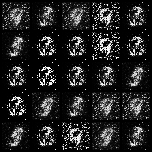

In [ ]:
import imageio
import glob
from IPython import display
import matplotlib.pyplot as plt
from PIL import Image

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

display.Image(filename=anim_file, width = 300, height = 300)

In [ ]:
!pip install git+https://github.com/tensorflow/docs
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)